In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # Para formatação dos eixos, se necessário


In [2]:

# Exemplo de valores (pode ser substituído por input do usuário)
f_str_exemplo = str('2*x*y') # Mesma EDO dos exemplos anteriores para consistência
x_exemplo = 1
y_exemplo = 2
h_exemplo = 0.1
interacoes_exemplo = 27

In [3]:


def resolver_edo_heun(f_str, x_inicial, y_inicial, h_passo, num_total_iteracoes):
    """
    Resolve uma EDO de primeira ordem dy/dx = f(x,y) usando o método de Heun.

    Args:
        f_str (str): A equação dy/dx = f(x,y) como string.
        x_inicial (float/int): Valor inicial de x (x0).
        y_inicial (float/int): Valor inicial de y (y0).
        h_passo (float/int): Tamanho do passo (h).
        num_total_iteracoes (int): Número de iterações a serem calculadas APÓS o ponto inicial.

    Returns:
        tuple: Contendo:
            - df (pd.DataFrame): DataFrame com os resultados das iterações.
            - equacao_info (str): String descrevendo a equação fornecida.
            - condicoes_info (str): String descrevendo as condições iniciais.
            - passo_info (str): String descrevendo o passo h.
            - num_iteracoes_info (str): String descrevendo o número de iterações.
        Retorna (None, error_message, None, None, None) em caso de erro na conversão
        de input ou na interpretação da função.
    """

    try:
        x0_global = float(x_inicial)
        y0_global = float(y_inicial)
        h = float(h_passo)
        num_iteracoes = int(num_total_iteracoes)
    except ValueError:
        error_msg = "Erro: Entrada inválida. Certifique-se de que os valores numéricos (x_inicial, y_inicial, h_passo, num_total_iteracoes) estão corretos."
        return None, error_msg, None, None, None

    try:
        allowed_names = {"x": None, "y": None, "math": math}
        def func(x_eval, y_eval):
            return eval(f_str, {"__builtins__": {}}, {**allowed_names, "x": x_eval, "y": y_eval})
        func(x0_global, y0_global) # Teste inicial
    except Exception as e:
        error_msg = f"Erro ao interpretar a função f(x,y) ('{f_str}'): {e}\n" \
            "Certifique-se de que a equação usa 'x' e 'y' como variáveis.\n" \
            "Para funções matemáticas, use o prefixo 'math.', por exemplo, 'math.sin(x)'."
        return None, error_msg, None, None, None

    equacao_info = f"Equação fornecida: dy/dx = {f_str}"
    condicoes_info = f"Condições iniciais: x0 = {x0_global}, y0 = {y0_global}"
    passo_info = f"Passo (h): {h}"
    num_iteracoes_info = f"Número de iterações após o ponto inicial: {num_iteracoes}"

    iter_col = []
    x_col = []
    y_col = []
    k1_col = []
    k2_col = []
    erro_col = []

    x_i = x0_global
    y_i = y0_global

    # Iteração 0 (ponto inicial)
    iter_col.append(0)
    x_col.append(x_i)
    y_col.append(y_i)

    k1_atual = func(x_i, y_i)
    k1_col.append(k1_atual)

    # Fórmula de Heun para k2
    k2_atual = func(x_i + h, y_i + k1_atual * h)
    k2_col.append(k2_atual)
    erro_col.append(float('nan'))

    # Loop para as iterações seguintes
    for i in range(1, num_iteracoes + 1):
        y_anterior_neste_passo = y_i # y_i da iteração anterior (y_{n-1})
        
        # k1 e k2 da iteração anterior (calculados no final do loop anterior ou na inicialização)
        k1_do_passo_anterior = k1_atual 
        k2_do_passo_anterior = k2_atual

        # Fórmula de Heun para y_{i+1}
        y_i = y_i + (k1_do_passo_anterior + k2_do_passo_anterior) * h / 2.0

        x_i = x0_global + i * h

        iter_col.append(i)
        x_col.append(x_i)
        y_col.append(y_i)

        # Calcula k1 e k2 para ESTA iteração (x_i, y_i atuais)
        # Estes serão usados para calcular o y da PRÓXIMA iteração
        k1_atual = func(x_i, y_i)
        k1_col.append(k1_atual)

        k2_atual = func(x_i + h, y_i + k1_atual * h)
        k2_col.append(k2_atual)

        erro_val = abs(y_i - y_anterior_neste_passo)
        erro_col.append(erro_val)

    df = pd.DataFrame({
        'Iter.': iter_col,
        'x0': x_col,
        'y0': y_col,
        'K1': k1_col,
        'K2': k2_col,
        'ERRO |yn-yn-1|': erro_col
    })

    return df, equacao_info, condicoes_info, passo_info, num_iteracoes_info


def gerar_grafico_edo_heun(df_resultados, titulo_grafico="Solução da EDO pelo Método de Heun"):
    """
    Gera e exibe um gráfico da solução da EDO (y0 vs x0) e do erro
    (|yn - y_{n-1}| vs x0) a partir de um DataFrame para o método de Heun.
    """
    if not isinstance(df_resultados, pd.DataFrame):
        print("Erro: A entrada deve ser um DataFrame do Pandas.")
        return
    required_cols = {'x0', 'y0', 'ERRO |yn-yn-1|'}
    if not required_cols.issubset(df_resultados.columns):
        print(f"Erro: O DataFrame deve conter as colunas {required_cols}.")
        return
    if df_resultados.empty:
        print("Erro: O DataFrame está vazio, nada para plotar.")
        return

    plt.figure(figsize=(12, 7))
    plt.plot(df_resultados['x0'], df_resultados['y0'], marker='o',
             linestyle='-', color='darkorange', label='$y_n$ (Solução Heun)')
    plt.plot(df_resultados['x0'], df_resultados['ERRO |yn-yn-1|'], marker='s',
             linestyle='--', color='teal', label='$|y_n - y_{n-1}|$ (Erro Aproximado)')

    plt.title(titulo_grafico, fontsize=16)
    plt.xlabel("$x_n$", fontsize=14)
    plt.ylabel("Valores", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    return plt


In [4]:

# --- Exemplo de uso do método de Heun ---
dataframe_heun, eq_info_heun, ci_info_heun, p_info_heun, ni_info_heun = resolver_edo_heun(
    f_str_exemplo,
    x_exemplo,
    y_exemplo,
    h_exemplo,
    interacoes_exemplo
)

Solução de EDO pelo Método de Heun
----------------------------------
Equação fornecida: dy/dx = 2*x*y
Condições iniciais: x0 = 1.0, y0 = 2.0
Passo (h): 0.1
Número de iterações após o ponto inicial: 27
----------------------------------

Resultados das Iterações:
 Iter.    x0          y0           K1           K2 ERRO |yn-yn-1|
     0 1.000      2.0000       4.0000       5.2800            NaN
     1 1.100      2.4640       5.4208       7.2146         0.4640
     2 1.200      3.0958       7.4298       9.9808         0.6318
     3 1.300      3.9663      10.3124      13.9931         0.8705
     4 1.400      5.1816      14.5084      19.8972         1.2153
     5 1.500      6.9019      20.7056      28.7117         1.7203
     6 1.600      9.3727      29.9927      42.0648         2.4709
     7 1.700     12.9756      44.1170      62.5943         3.6029
     8 1.800     18.3112      65.9202      94.6321         5.3356
     9 1.900     26.3388     100.0873     145.3900         8.0276
    10 2.0

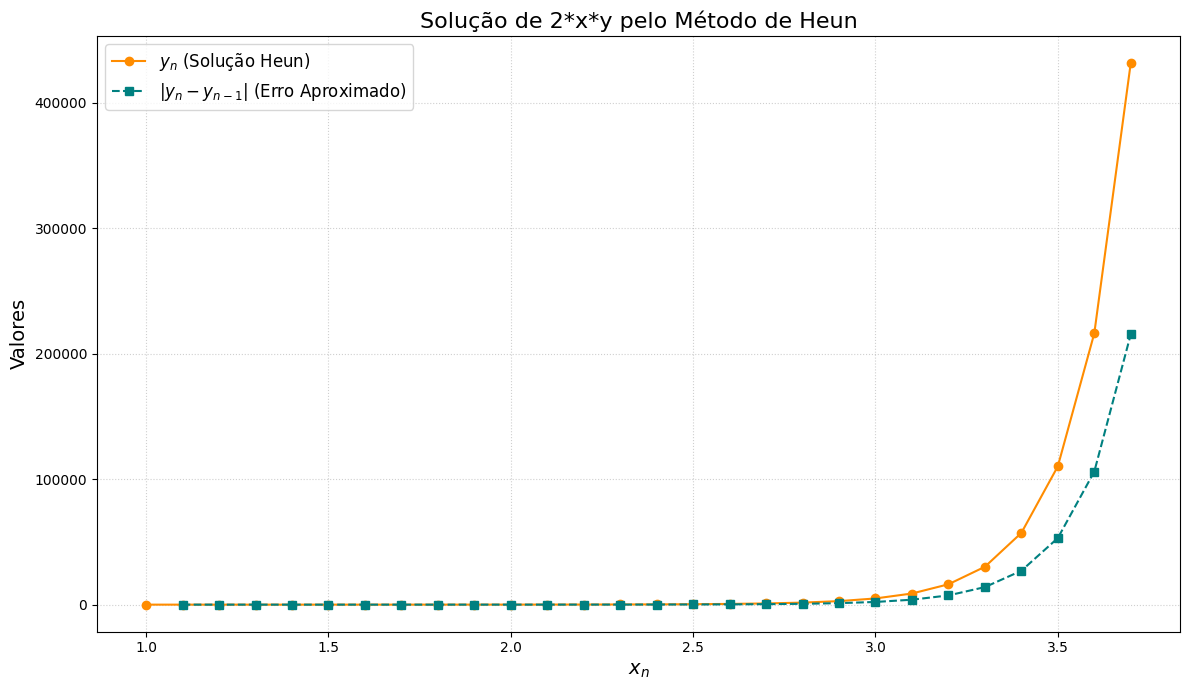

In [5]:

if dataframe_heun is not None:
    print("Solução de EDO pelo Método de Heun")
    print("----------------------------------")
    print(eq_info_heun)
    print(ci_info_heun)
    print(p_info_heun)
    print(ni_info_heun)
    print("----------------------------------\n")
    print("Resultados das Iterações:")

    # Formatação para o DataFrame de Heun, baseado na imagem fornecida:
    # x0: 3 casas (1.000)
    # y0: 4 casas (2.4640)
    # K1: variável, até 3 casas (4, 5.421, 7.43, 10.31, 100.1)
    # K2: variável, até 4 casas (5.28, 7.2146, 9.9808, 13.993)
    # ERRO: 4 casas (0.4640)
    # Para consistência, usaremos 4 casas decimais para K1 e K2 no display,
    # o que pode mostrar mais precisão do que a imagem em alguns casos.
    formatters_heun = {
        'x0': '{:.3f}'.format,
        'y0': '{:.4f}'.format,
        'K1': '{:.4f}'.format, # Ajustado para 4 casas para consistência com K2
        'K2': '{:.4f}'.format,
        'ERRO |yn-yn-1|': '{:.4f}'.format
    }
    print(dataframe_heun.to_string(index=False, na_rep='NaN', formatters=formatters_heun))

    grafico_heun = gerar_grafico_edo_heun(
        dataframe_heun, titulo_grafico=f"Solução de {f_str_exemplo} pelo Método de Heun"
    )
    # grafico_heun.show() # Descomente para exibir o gráfico
    print("\nGráfico gerado (descomente plt.show() na função ou aqui para exibir).")

else:
    print(f"Não foi possível calcular a solução: {eq_info_heun}")

print("\n--- Exemplo com erro na equação (Heun) ---")
dataframe_erro_heun, msg_erro_heun, _, _, _ = resolver_edo_heun(
    "math.exp(x) - y*z",  # Equação com variável 'z' não definida
    0, 1, 0.2, 5
)

In [6]:
dataframe_heun

,Iter.,x0,y0,K1,K2,ERRO |yn-yn-1|
0,0,1.0,2.000000,4.000000e+00,5.280000e+00,NaN
1,1,1.1,2.464000,5.420800e+00,7.214592e+00,0.464000
2,2,1.2,3.095770,7.429847e+00,9.980761e+00,0.631770
3,3,1.3,3.966300,1.031238e+01,1.399311e+01,0.870530
4,4,1.4,5.181574,1.450841e+01,1.989725e+01,1.215274
5,5,1.5,6.901857,2.070557e+01,2.871173e+01,1.720283
6,6,1.6,9.372722,2.999271e+01,4.206478e+01,2.470865
7,7,1.7,12.975596,4.411703e+01,6.259428e+01,3.602874
8,8,1.8,18.311161,6.592018e+01,9.463208e+01,5.335565
9,9,1.9,26.338774,1.000873e+02,1.453900e+02,8.027613
